# 1 - Decision Trees/Random Forests


Ein Entscheidungsbaummodell ist ein supervisiertes Machine Learning Modell, das Entscheidungsregeln in Form eines baumartigen Struktur darstellt. Der Baum besteht aus Knoten, die Entscheidungen repräsentieren, und Kanten, die zu anderen Knoten führen. Jeder Knoten stellt eine Funktion dar, die anhand von Merkmalswerten entscheidet, welcher Pfad im Baum zu folgen ist.

Das Modell beginnt mit einem Wurzelknoten, der das gesamte Datenset repräsentiert. An jedem Knoten werden die Daten anhand eines ausgewählten Merkmals aufgeteilt. Diese Aufteilung erfolgt so, dass die Homogenität der Daten innerhalb der Gruppen maximiert wird. Zum Beispiel können numerische Merkmale anhand von Schwellenwerten aufgeteilt werden, während kategoriale Merkmale in verschiedene Kategorien unterteilt werden können.

Dieser Prozess wird rekursiv fortgesetzt, indem die Daten anhand verschiedener Merkmale aufgeteilt werden, bis ein vordefiniertes Stoppkriterium erfüllt ist, wie beispielsweise das Erreichen einer maximalen Tiefe des Baumes oder das Erreichen einer Mindestanzahl von Datenpunkten in einem Blattknoten.

Nachdem der Baum erstellt wurde, kann er zur Vorhersage von Zielvariablen verwendet werden, indem neue Daten durch den Baum geleitet werden, und jede Instanz endet in einem Blattknoten, der eine Vorhersage für die Zielvariable liefert. Das Entscheidungsbaummodell ist einfach zu verstehen und zu interpretieren, was es zu einer beliebten Wahl für verschiedene Aufgaben des maschinellen Lernens macht.

[ScikitLearn DecisionTree documentation](https://scikit-learn.org/stable/modules/tree.html#tree)

[Video über das Decision Tree Algorithmus](https://www.youtube.com/watch?v=_L39rN6gz7Y&t=2s)

[<img src="bilder/Decision_Tree_algorithm.png"  width="700" height="500"  title="Decision Tree">](https://www.saedsayad.com/decision_tree.htm)

In [1]:
from sklearn import tree, metrics, ensemble
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/tmp/ipykernel_54472/2475676374.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Wir laden wieder unsere Klasse
%load_ext autoreload
%autoreload 2

from model import model_poverty_prob

In [3]:
# und unser Pickle
import pickle

with open('mod_.pkl', 'rb') as file:
    mod_ = pickle.load(file)

In [4]:
# Wir entscheiden die Merkmale wir wollen in unser Modell (nur weniger, damit wir den Baum sehen können)
vars = ['female','is_urban',]

In [5]:
# und wir deffinieren ein Regression Entscheidungsbaum
dt_reg = tree.DecisionTreeRegressor()
dt_reg = dt_reg.fit(mod_.X_train[vars], mod_.y_train)
dt_reg.predict(mod_.X_test[vars])

array([0.46855   , 0.50486788, 0.68362087, ..., 0.68362087, 0.64878833,
       0.68362087])

In [6]:
dt_reg.feature_names_in_

array(['female', 'is_urban'], dtype=object)

In [7]:
dt_reg.feature_importances_

array([0.04155373, 0.95844627])

ScikitLearn hat eine Methode, um den Baum zu zeigen.

[ScikitLearn DecisionTree plot](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py)

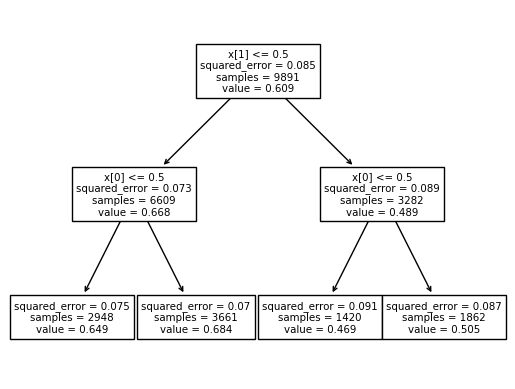

In [8]:
tree.plot_tree(dt_reg)
plt.show()

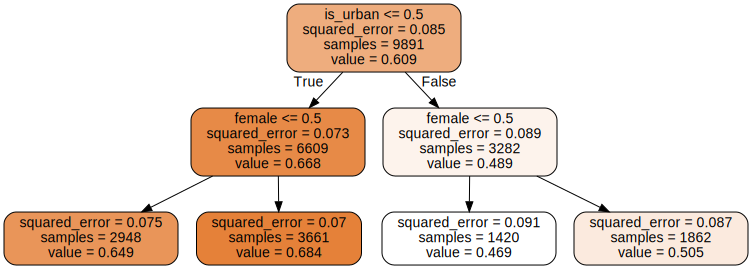

In [9]:
# aber es sieht deutlich besser aus mit graphviz...

import graphviz

tree.export_graphviz(dt_reg, out_file="dt_reg.dot", 
                feature_names=mod_.X_train[vars].columns,
                # class_names=['0','1','2'], 
                rounded=True, filled=True)

# Import model graph
with open("dt_reg.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

# dot_data = tree.export_graphviz(dt_reg, out_file=None) 
# graph = graphviz.Source(dot_data) 
# graph


In [10]:
# was ist die Leistung von unserem Entshceidungsbaum?
metrics.mean_squared_error(mod_.y_test,dt_reg.predict(mod_.X_test[vars]))

0.07673741562141873

In [11]:
# wir können auch die gleiche Metrik für das OLS Modell berechnen

metrics.mean_squared_error(mod_.y_test,mod_.model_OLS.predict(pd.merge(pd.DataFrame(
    data={'const' : [1 for i in range(mod_.X_test.shape[0])]},
    index=mod_.X_test[mod_.model_OLS.params.index[1:]].index),
         mod_.X_test[mod_.model_OLS.params.index[1:]],
        left_index = True, right_index = True)))

0.05904820374275114

In [12]:
dt_reg = tree.DecisionTreeRegressor()
dt_reg = dt_reg.fit(mod_.X_train[vars], mod_.y_train)

In [13]:
dt_reg.feature_names_in_

array(['female', 'is_urban'], dtype=object)

In [14]:
# wir wollen das Entscheidungsbaummodell und den MSE zu unserem model py Datei übertragen
mod_.tree_mod(vars)

In [15]:
mod_.mean_squared_error()

In [16]:
mod_.mse

,OLS,Tree
mean squared error,0.059048,0.076737


In [17]:
vars = mod_.model_OLS.params.drop('const').index

In [18]:
mod_.tree_mod(vars)

In [19]:
mod_.mean_squared_error()
mod_.mse

,OLS,Tree
mean squared error,0.059048,0.058074


In [20]:
mod_.tree_mod(vars,20)

In [21]:
mod_.mean_squared_error()
mod_.mse

,OLS,Tree
mean squared error,0.059048,0.056009


<h4>Random Forest</h4>

Während Entscheidungsbäume viele Vorteile haben, neigen sie dazu, schnell zu overfitten. Eine ähnliche Methode, die damit umgeht, ist der Random Forest.

Ein Random Forest ist ein ensemble-basiertes maschinelles Lernmodell, das aus einer Sammlung von Entscheidungsbäumen besteht. Der Algorithmus funktioniert wie folgt:

- Bootstrapping: Zuerst werden zufällig mehrere Teilsets (Bootstraps) aus dem Trainingsdatensatz gezogen. Diese Teilsets enthalten zufällige Untergruppen von Beobachtungen mit Wiederholung.

- Erstellung von Entscheidungsbäumen: Für jedes Teilset wird ein Entscheidungsbaum erstellt. Dabei werden an jedem Knoten des Baumes zufällig ausgewählte Merkmale verwendet, um die Daten zu teilen. Dies bedeutet, dass jeder Baum auf einem zufälligen Unterdatensatz basiert und unterschiedliche Entscheidungen trifft.

- Vorhersage: Wenn eine Vorhersage gemacht werden soll, wird jeder Baum im Wald über die Eingabeinstanz geführt, und die Ergebnisse der einzelnen Bäume werden kombiniert. Bei einer Klassifizierung wird eine Mehrheitsabstimmung durchgeführt, um die endgültige Klasse zu bestimmen. Bei einer Regression wird der Durchschnitt der Vorhersagen der einzelnen Bäume genommen.

Der Random Forest Algorithmus ist bekannt für seine Robustheit gegenüber Overfitting und seine Fähigkeit, mit hochdimensionalen Daten umzugehen. Durch die Kombination mehrerer Entscheidungsbäume kann er komplexe Zusammenhänge in den Daten erfassen und gleichzeitig eine hohe Vorhersagegenauigkeit erzielen.

[SickitLearn Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

[Video über das Random Forest Algorithmus](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ)

[<img src="bilder/Random-Forest-Introduction.jpg"  width="700" height="500"  title="Random Forest">](https://dataaspirant.com/random-forest-algorithm-machine-learing/)


In [ ]:
mod_.forest_mod(vars,200,60)

In [ ]:
mod_.mean_squared_error()
mod_.mse

In [ ]:
forest = ensemble.RandomForestRegressor(n_estimators=200,min_samples_leaf=60)

cv_results = cross_validate(forest, mod_.X_train[vars], mod_.y_train, scoring = "neg_mean_squared_error", cv=5)

In [ ]:
-1*(np.mean(cv_results['test_score']))

In [ ]:
cv_results

## 2 - Neural Networks

Ein neuronales Netzwerk ist ein maschinelles Lernmodell, das von der Funktionsweise des menschlichen Gehirns inspiriert ist. Es besteht aus mehreren Schichten von künstlichen Neuronen, die miteinander verbunden sind. Die Funktionsweise eines neuronalen Netzwerks kann wie folgt erklärt werden:

- Eingabeschicht: Die Eingabeschicht erhält die Eingangsdaten, die als Merkmale oder Attribute repräsentiert werden. Jedes Merkmal wird einem Neuron in der Eingabeschicht zugeordnet.

- Versteckte Schichten: Zwischen der Eingabeschicht und der Ausgabeschicht können eine oder mehrere versteckte Schichten vorhanden sein. Jede versteckte Schicht besteht aus einer Reihe von Neuronen, die miteinander verbunden sind. In diesen Schichten werden komplexe Berechnungen durchgeführt, um Muster in den Eingangsdaten zu erkennen.

- Gewichtungen und Aktivierungsfunktionen: Die Verbindungen zwischen den Neuronen haben Gewichtungen, die während des Trainings angepasst werden, um die Leistung des Modells zu verbessern. Jedes Neuron wendet auch eine Aktivierungsfunktion auf die gewichtete Summe seiner Eingaben an, um seine Ausgabe zu generieren.

- Ausgabeschicht: Die Ausgabeschicht liefert die Vorhersagen des Modells. Die Anzahl der Neuronen in dieser Schicht hängt von der Art des Problems ab, das das neuronale Netzwerk lösen soll. Zum Beispiel wird bei einer Klassifikationsaufgabe mit zwei Klassen eine Neuronen in der Ausgabeschicht verwendet, während bei einer mehrklassigen Klassifikationsaufgabe eine Neuronen für jede Klasse vorhanden ist.

- Training: Das neuronale Netzwerk wird durch das Trainieren mit beschrifteten Trainingsdaten entwickelt. Während des Trainings passen wir die Gewichtungen der Verbindungen an, um die Vorhersagen des Netzwerks zu verbessern und die Fehler zu minimieren.

Ein neuronales Netzwerk kann komplexe nichtlineare Beziehungen zwischen den Eingangsdaten erfassen und ist in der Lage, eine Vielzahl von Aufgaben im maschinellen Lernen zu lösen, einschließlich Klassifikation, Regression, Clustering und mehr.

[MIT Buch von Januar 2024](https://udlbook.github.io/udlbook/)

- Das **neuronale Netzwerk** besteht aus sequenziellen Schichten von verbundenen Neuronen, die das empfangene Signal vorwärts übertragen.
  
[<img src="bilder/NN_simple.svg"  width="600" height="300"  title="NN Mathematik">](https://victorzhou.com/blog/intro-to-neural-networks/)

- Die konstitutiven Bestandteile eines **Neurons** in einem neuronalen Netzwerk sind:

    - Eingaben (Inputs): Die Eingaben sind die Signale oder Werte, die von anderen Neuronen oder externen Quellen an das Neuron gesendet werden.

    - Gewichtungen (Weights): Jede Eingabe wird mit einer spezifischen Gewichtung multipliziert, die angibt, wie wichtig diese Eingabe für das Neuron ist. Diese Gewichtungen werden während des Trainings angepasst, um die Leistung des Netzwerks zu verbessern.

    - Summationsfunktion (Summation Function): Die gewichteten Eingaben werden addiert, um eine gewichtete Summe zu berechnen.

    - Aktivierungsfunktion (Activation Function): Die gewichtete Summe wird einer Aktivierungsfunktion zugeführt, die den Ausgabewert des Neurons bestimmt. Die Aktivierungsfunktion führt oft eine nichtlineare Transformation durch, um die Fähigkeit des Neurons zur Erfassung komplexer Muster zu verbessern.

    - Bias (Bias): Ein Bias-Term wird oft zu der gewichteten Summe hinzugefügt, um die Flexibilität des Neurons zu erhöhen und es zu ermöglichen, auch dann zu feuern, wenn alle Eingaben null sind.

    - Ausgabe (Output): Die Ausgabe des Neurons wird basierend auf dem Ergebnis der Aktivierungsfunktion generiert und kann an andere Neuronen in der nächsten Schicht weitergegeben werden.

[<img src="bilder/neuron_zoom_in.png"  width="600" height="300"  title="NN Zoom in">](https://www.v7labs.com/blog/neural-network-architectures-guide)

- Aktivierungsfunktionen (Activation Functions): Die Auswahl der Aktivierungsfunktionen in den Neuronen beeinflusst die Nichtlinearität des Modells und seine Fähigkeit, komplexe Muster zu erfassen. Gängige Aktivierungsfunktionen sind die Sigmoidfunktion, die ReLU (Rectified Linear Unit) und die Tanh-Funktion.

[<img src="bilder/Activation_functions.jpg"  width="600" height="300"  title="NN Activation functions">](https://www.researchgate.net/figure/Fig-3-The-basic-activation-functions-of-the-neural-networksNeural-Networks_fig3_350567223)


[**Tensorflow Playground**](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.24218&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:

# um eine Netzwerk zu bauen, wir nutzen die Sequential Klasse
model = Sequential()

# dann können wir sukzessive weitere Neuronenschichten hinzufügen.
# es ist eine gute Praxis, in der ersten Schicht explizit anzugeben, wie viele Merkmale in das Modell eingehen werden

model.add(layers.Dense(5, input_dim=mod_.X_train[vars].shape[1],activation='relu'))
model.add(layers.Dropout(rate=0.2))  # The rate is the percentage of neurons that are "killed"
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(rate=0.2))  # The rate is the percentage of neurons that are "killed"
model.add(layers.Dense(10, activation='relu'))

# in der letzten Schicht müssen wir angeben, wie viele Ausgänge wir wollen, und eine geeignete Aktivierungsfunktion wählen
model.add(layers.Dense(1, activation='linear'))

# wie viele Parameter müssen wir bei der Anpassung berechnen?
model.summary()

In [ ]:
# ### Klassifizierung mit 2 Klassen 
# model.add(layers.Dense(1, activation='sigmoid'))


# ### Klassifizierung mit 8 Klassen 
# model.add(layers.Dense(8, activation='softmax'))

In einem Neural Network Training können verschiedene Parameter angepasst werden, um die Leistung des Modells zu optimieren. Dazu gehören:

- Lernrate (Learning Rate): Bestimmt die Größe der Schritte, die während des Trainings zur Aktualisierung der Gewichtungen gemacht werden. Eine niedrige Lernrate kann zu langsamerem Lernen führen, während eine hohe Lernrate dazu führen kann, dass das Modell nicht konvergiert oder instabil wird.

[<img src="bilder/NN-LR.png"  width="600" height="300"  title="NN Learning Rate">](https://www.jeremyjordan.me/nn-learning-rate/)


- Batchgröße (Batch Size): Legt fest, wie viele Beispiele gleichzeitig durch das Netzwerk geleitet und zur Aktualisierung der Gewichtungen verwendet werden. Eine größere Batchgröße kann das Training beschleunigen, während eine kleinere Batchgröße eine genauere Schätzung des Gradienten ermöglichen kann. Der meistens benutzt Batch Size ist 32.


<img src="bilder/NN-BS.png"  width="600" height="300"  title="NN Batch Size">

- Verlustfunktion (Loss Function): Die Funktion, die den Unterschied zwischen den Vorhersagen des Modells und den tatsächlichen Werten misst und minimiert werden soll. Oft wird der Mean Squared Error für Regression und die Kategorische Kreuzentropie-Verlustfunktion für Klassifikation verwendet.

- Anzahl der Epochen (Number of Epochs): Die Anzahl der Epochen bestimmt, wie oft das gesamte Trainingsdatenset während des Trainings durchlaufen wird. Eine zu geringe Anzahl von Epochen kann zu Underfitting führen, während eine zu hohe Anzahl von Epochen zu Overfitting führen kann.

[<img src="bilder/NN-curves.png"  width="600" height="300"  title="NN Training Curves">](hhttps://www.kaggle.com/code/ryanholbrook/overfitting-and-underfitting)


- Optimierungsalgorithmen (Optimization Algorithms): Unterschiedliche Optimierungsalgorithmen wie Gradientenabstieg, Stochastic Gradient Descent (SGD) oder Adam können verwendet werden, um die Gewichtungen des Netzwerks zu aktualisieren und den Verlust während des Trainings zu minimieren.

In [ ]:
# Es gibt mehrere verschiedene Optimierer mit unterschiedlichen Kompromissen
# Adam (Adaptive Moment Estimation) ist eine zusammengesetzte Methode 

opt = Adam(
    learning_rate=0.0005
)


In [ ]:
# wir mussen explizit die 
model.compile(loss='mse', optimizer=opt)

In [ ]:
history = model.fit(mod_.X_train[vars].to_numpy(), 
          mod_.y_train.to_numpy(), 
          batch_size=32, 
          epochs=30,
          validation_split=0.2,
          verbose = True,
         )

In [ ]:
# um die Leistung unseres Modells zu überprüfen, verwenden wir die evaluate-Funktion
model.evaluate(mod_.X_test[vars], mod_.y_test)

In [ ]:
# und wir können auch die Trainingkurven Grafisch sehen
pd.DataFrame(history.history).plot()

In [ ]:
# es ist nicht möglich zu wissen, wie viele Epochen wir brauchen.
# aber wir können den Trainingsprozess beobachten und Abbruchkriterien festlegen. 
# in diesem Fall spielt die Anzahl der Epochen keine Rolle, der Prozess läuft weiter, bis die Abbruchkriterien erfüllt sind.

es = EarlyStopping(patience = 5, 
                   restore_best_weights=True,
                   monitor='val_loss',
                  )

history = model.fit(mod_.X_train[vars].to_numpy(), 
          mod_.y_train.to_numpy(), 
          batch_size=32, 
          epochs=300,
          validation_split=0.2,
          verbose = True,
          callbacks=[es])

In [ ]:
pd.DataFrame(history.history)[5:].plot()

In [ ]:
model.evaluate(mod_.X_test[vars], mod_.y_test)